In [1]:
%load_ext autoreload

In [ ]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Some Data

In [ ]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [ ]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [ ]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [ ]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [ ]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [ ]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [ ]:
session_info['drugStart']

In [ ]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [ ]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

# Parameter Search

In [ ]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([15000]),
#     matrix_size_vals=np.array([6400]),
#     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
#     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
#     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
# )
parameter_grid = ParameterGrid(
    window_vals=np.array([15000]),
    matrix_size_vals=np.array([6400]),
    r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 5, 10]),
    lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
)

In [ ]:
# wake_ret = parameter_search(wake_signal[:15000], wake_signal[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

In [15]:
# pd.to_pickle(wake_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_{area}.pkl'))
wake_ret = pd.read_pickle(os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'wake_ret_mary_normed_{area}.pkl'))

In [52]:
anesthesia_ret = parameter_search(anesthesia_signal[:15000], anesthesia_signal[15000:], parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True)

  0%|          | 0/2856 [00:00<?, ?it/s]

In [53]:
pd.to_pickle(anesthesia_ret, os.path.join('/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp', f'anesthesia_ret_mary_normed_{area}.pkl'))

# Performance

In [58]:
r_thresh_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.r_thresh.unique()])
lamb_vals = np.array([val if val < 1e-1 else float(val) for val in wake_ret.lamb.unique()])

wake_ip = np.zeros((len(lamb_vals), len(r_thresh_vals)))
anesthesia_ip = np.zeros((len(lamb_vals), len(r_thresh_vals)))

for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_ip[j, i] = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].ip
        if np.isnan(wake_ip[j, i]):
            wake_ip[j, i] = -1
        elif wake_ip[j, i] < -1:
            wake_ip[j, i] = -1
        
        anesthesia_ip[j, i] = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].ip
        if np.isnan(anesthesia_ip[j, i]):
            anesthesia_ip[j, i] = -1
        elif anesthesia_ip[j, i] < -1:
            anesthesia_ip[j, i] = -1

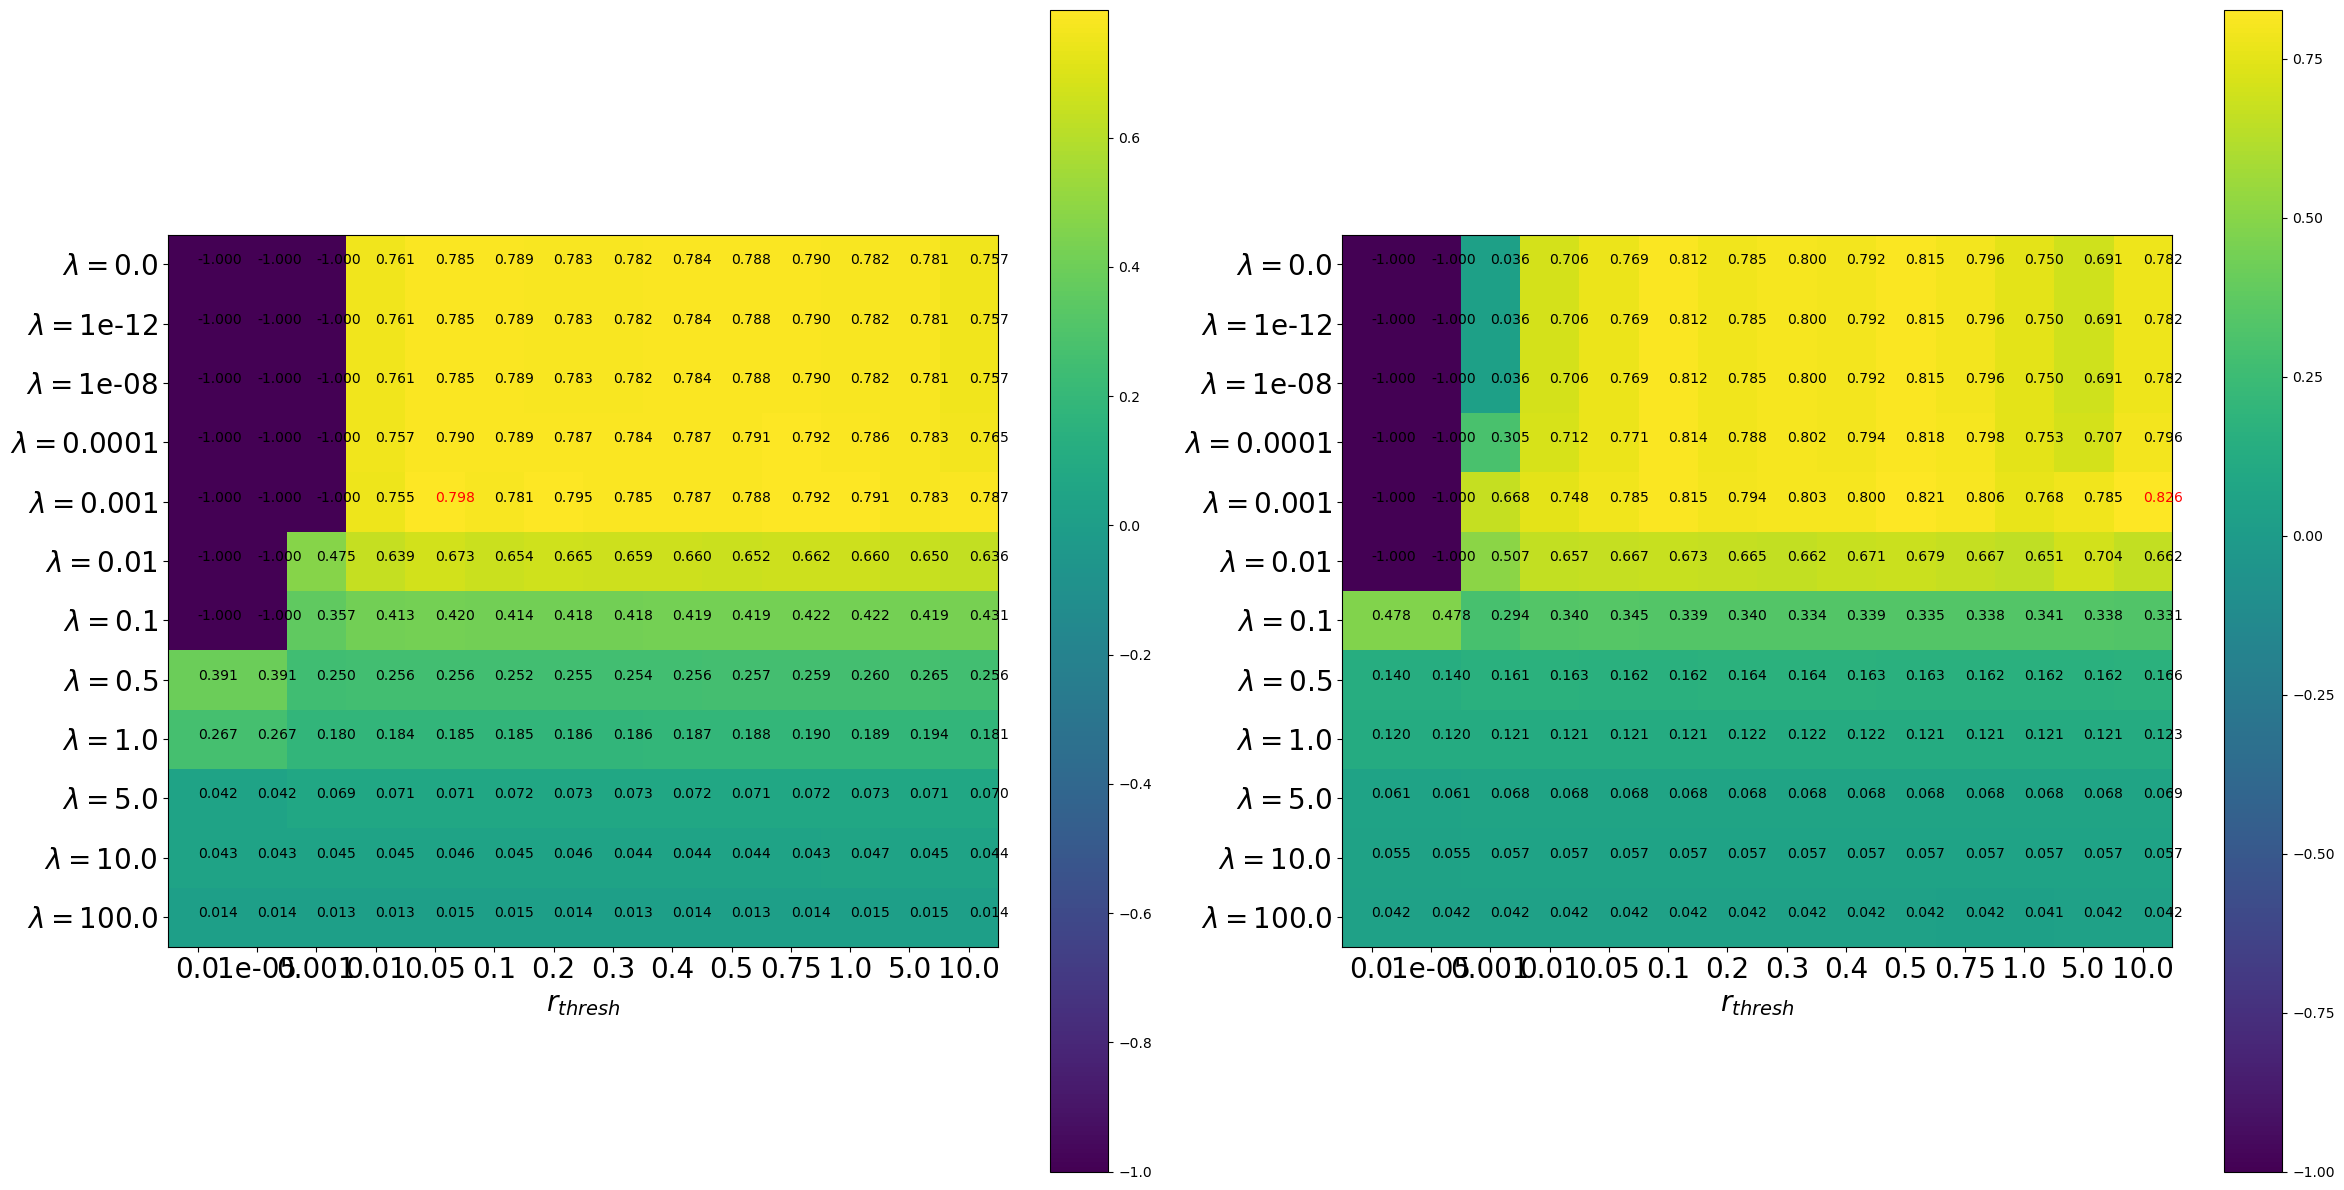

In [63]:
# min_r_thresh = 0.01
ip = wake_ip
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.imshow(ip)
plt.colorbar()
plt.xticks(np.arange(len(r_thresh_vals[filter_r_thresh])), [f"{r_thresh}" for r_thresh in r_thresh_vals[filter_r_thresh]])
plt.xlabel("$r_{thresh}$", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{r_thresh}" for r_thresh in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
 

ip = anesthesia_ip
plt.subplot(1, 2, 2)
plt.imshow(ip)
plt.colorbar()
plt.xticks(np.arange(len(r_thresh_vals[filter_r_thresh])), [f"{r_thresh}" for r_thresh in r_thresh_vals[filter_r_thresh]])
plt.xlabel("$r_{thresh}$", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{r_thresh}" for r_thresh in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip.max()
for i in range(ip.shape[0]):
    for j in range(ip.shape[1]):
        if ip[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

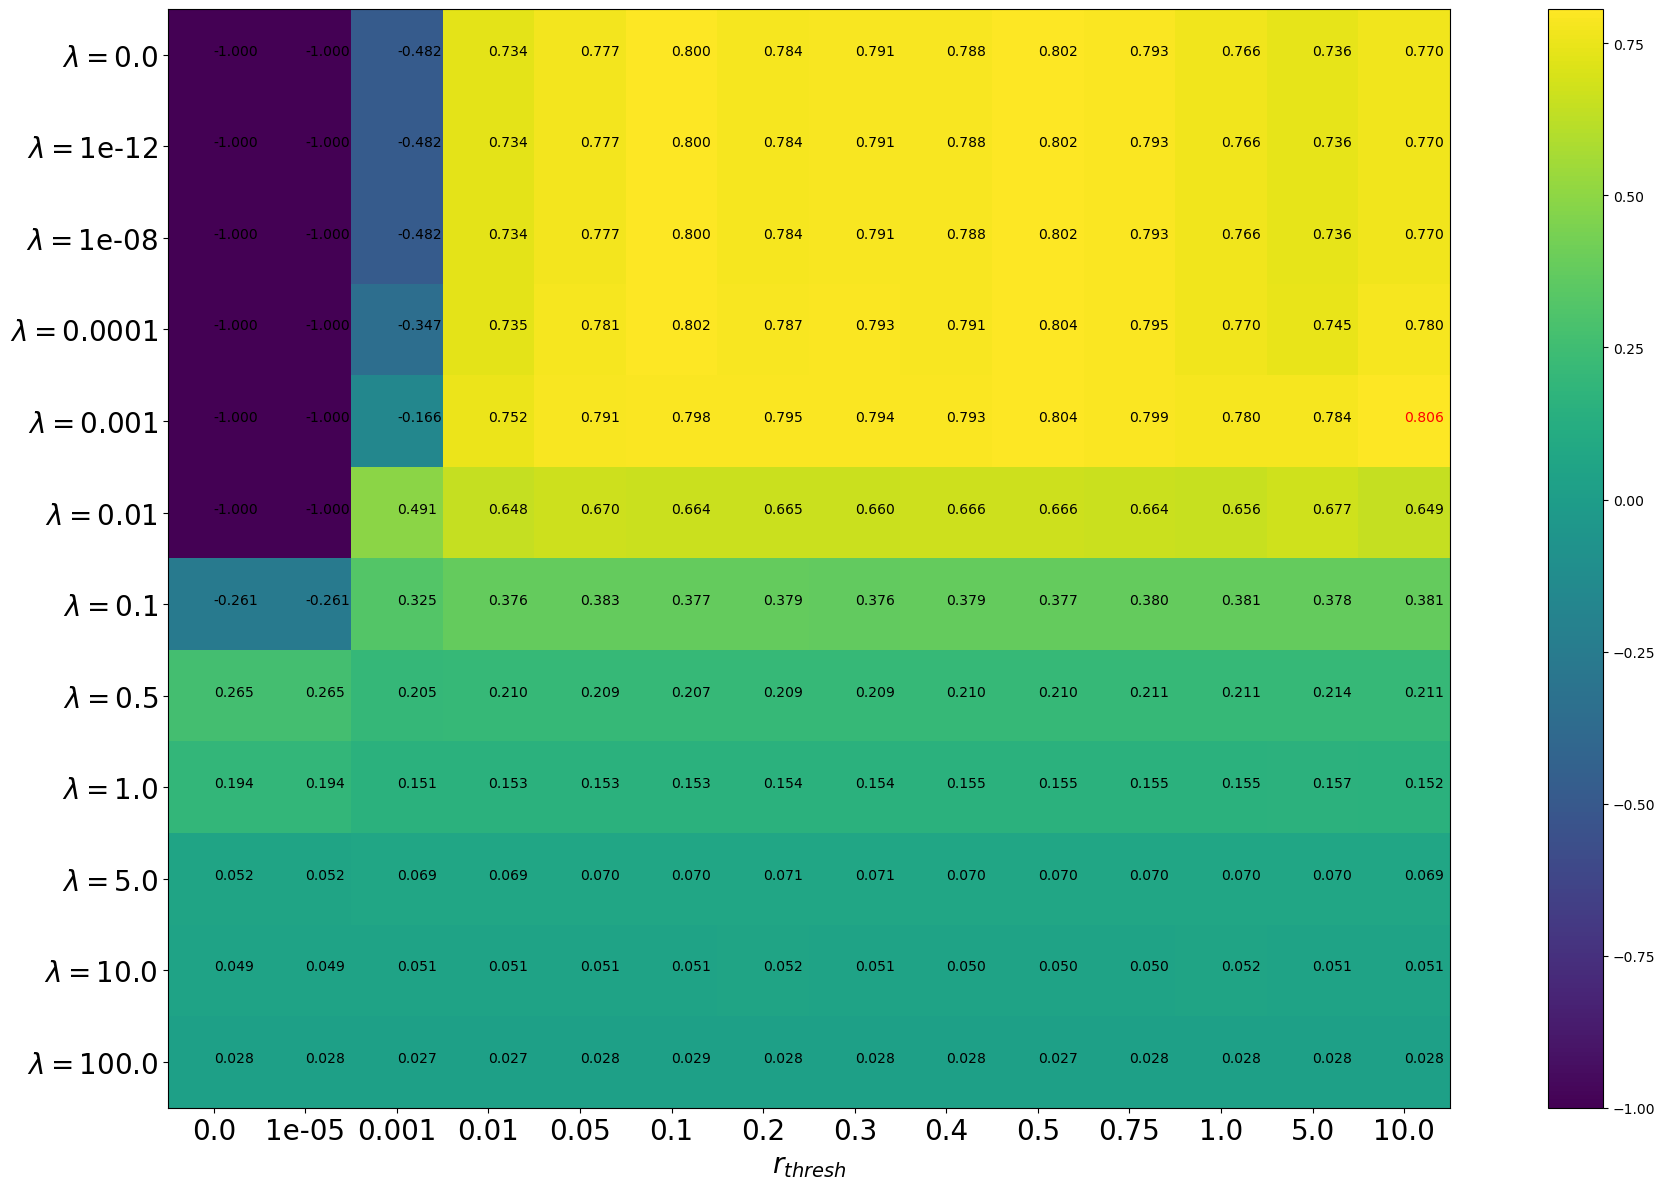

In [59]:
plt.figure(figsize=(20, 12))
ip_mat = (anesthesia_ip + wake_ip)/2
plt.imshow(ip_mat)
plt.colorbar()
plt.xticks(np.arange(len(r_thresh_vals)), [f"{r_thresh}" for r_thresh in r_thresh_vals])
plt.xlabel("$r_{thresh}$", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{r_thresh}" for r_thresh in lamb_vals])
plt.gca().tick_params(labelsize=20)
max_val = ip_mat.max()
for i in range(ip_mat.shape[0]):
    for j in range(ip_mat.shape[1]):
        if ip_mat[i, j] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip_mat[i, j]:.3f}", color=c)
plt.tight_layout()
plt.show()

# Stability

In [60]:
# top_percent = 20
# wake_stab = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(len(x)*top_percent)]).to_numpy()[0]
# anesthesia_stab = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(len(x)*top_percent)]).to_numpy()[0]

In [71]:
top_percent = 0.2

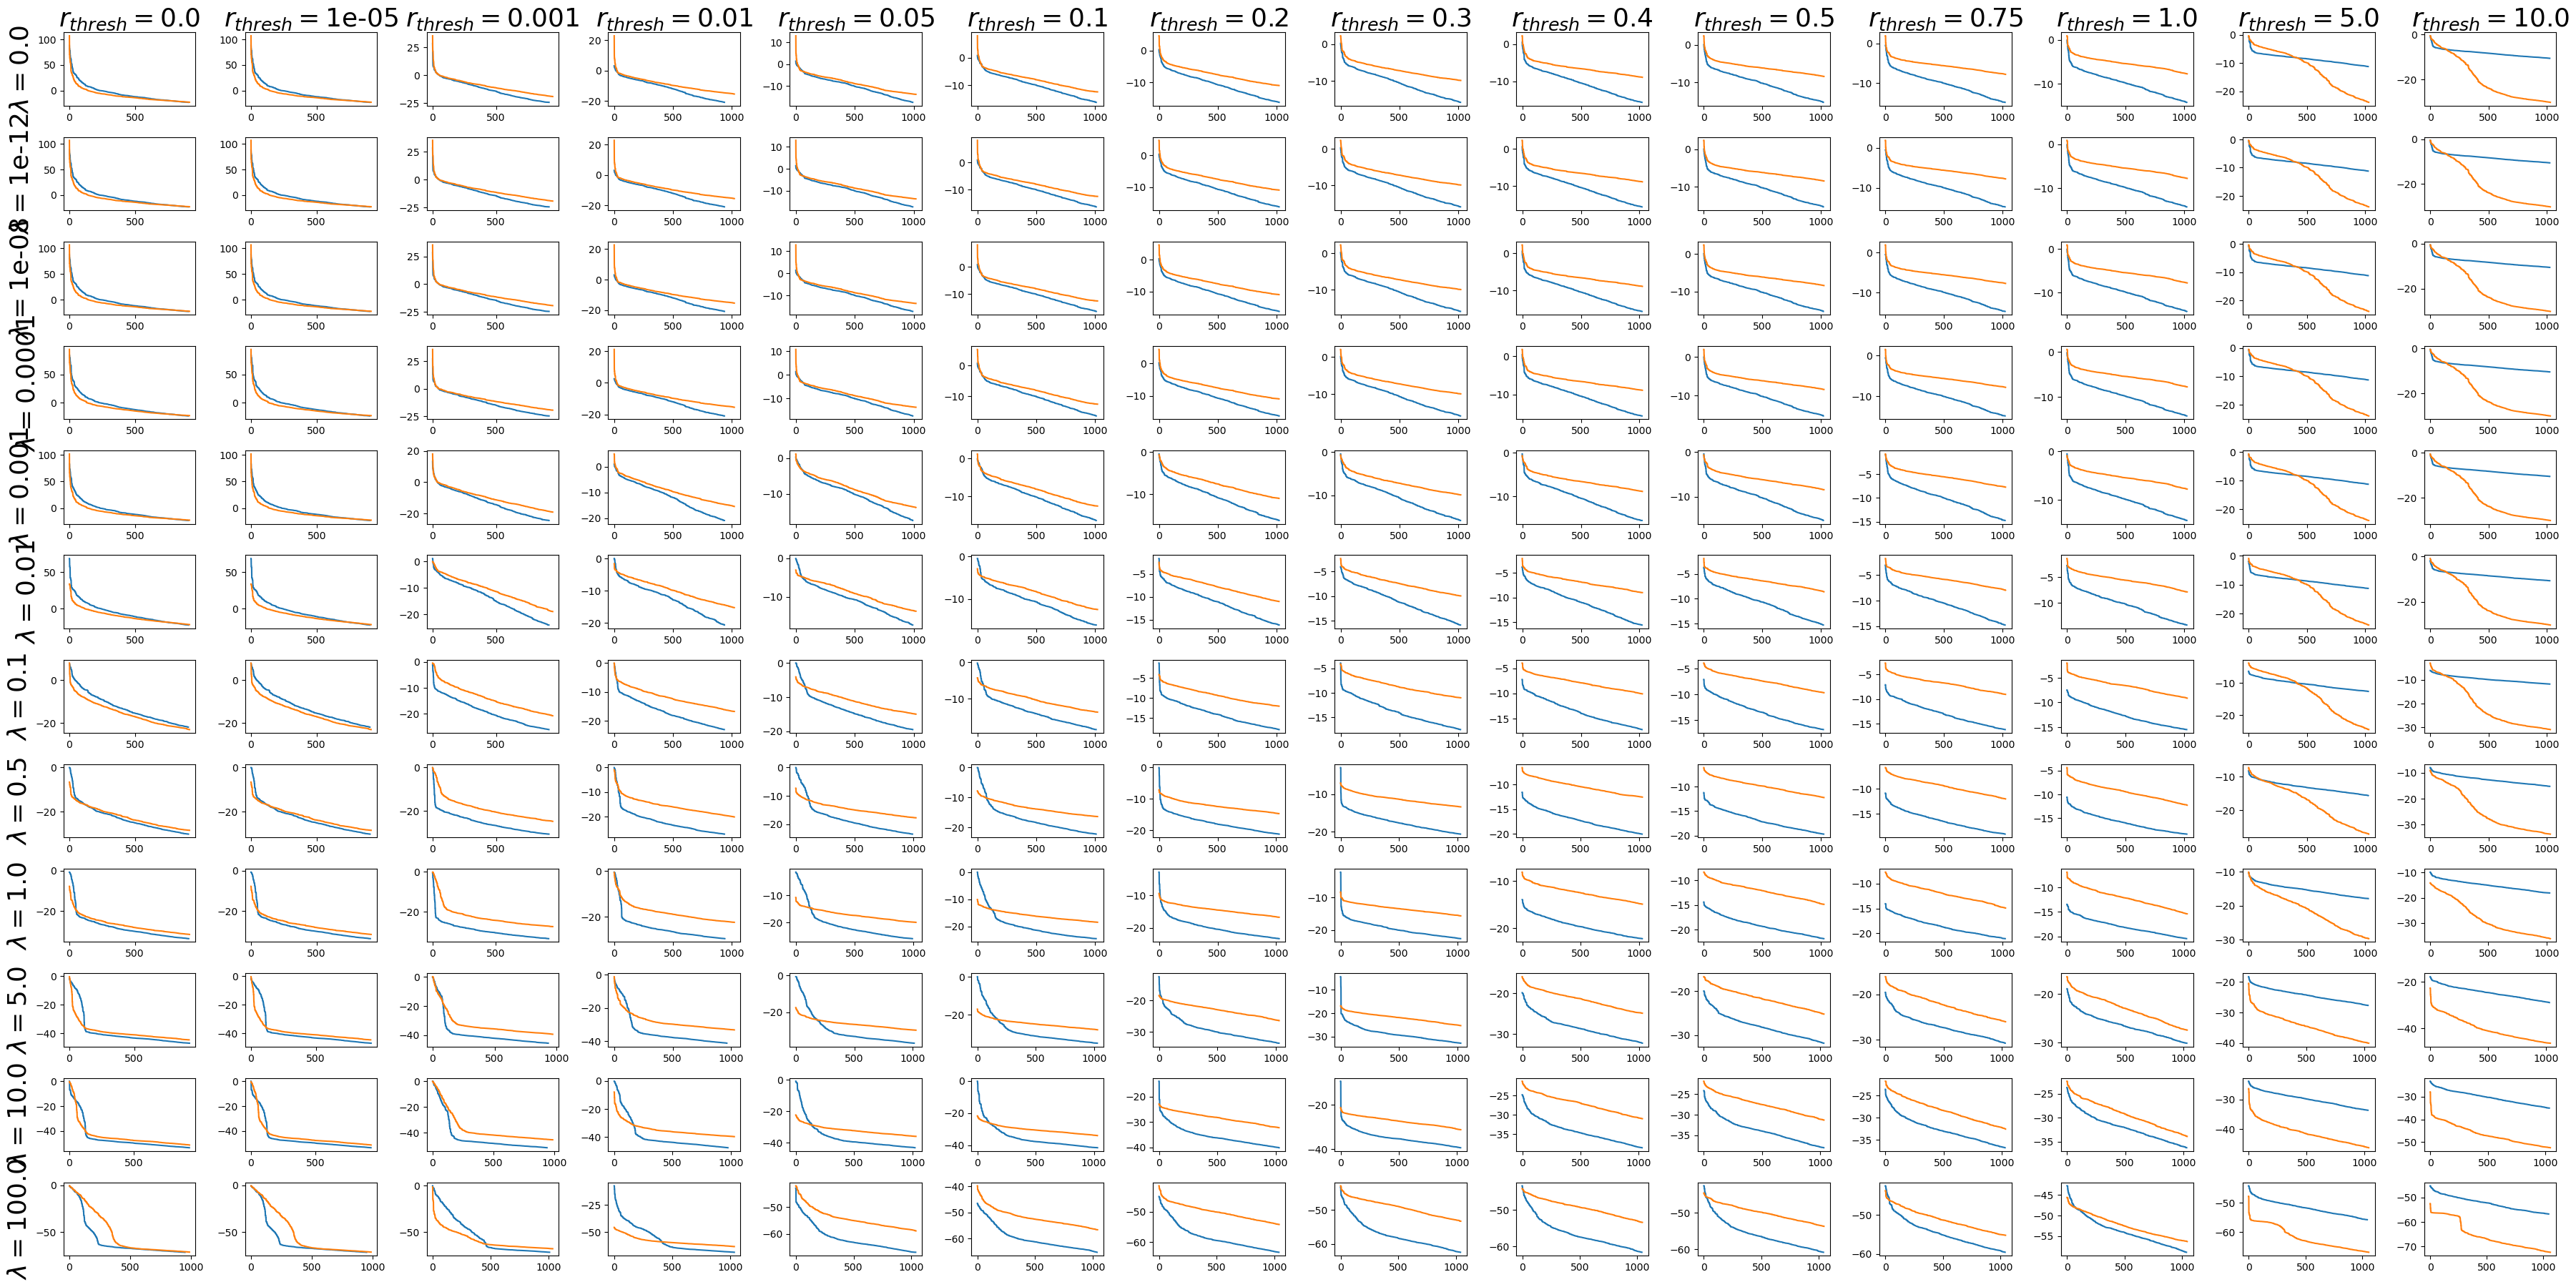

In [72]:
fig, axs = plt.subplots(len(lamb_vals), len(r_thresh_vals), figsize=(36, 18))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_curve = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        ax = axs[j, i]
        ax.plot(wake_curve)
        ax.plot(anesthesia_curve)
#         ax2.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r_{thresh} = $" + f"{r_thresh}", fontsize=26)
plt.tight_layout()
plt.show()

0.01 0.0
0.01 1e-12
0.01 1e-08
0.01 0.0001
0.01 0.001
0.05 0.0
0.05 1e-12
0.05 1e-08
0.05 0.0001
0.05 0.001
0.1 0.0
0.1 1e-12
0.1 1e-08
0.1 0.0001
0.1 0.001
0.2 0.0
0.2 1e-12
0.2 1e-08
0.2 0.0001
0.2 0.001
5.0 0.0001
5.0 0.001
5.0 0.01
10.0 0.0
10.0 1e-12
10.0 1e-08
10.0 0.0001
10.0 0.001


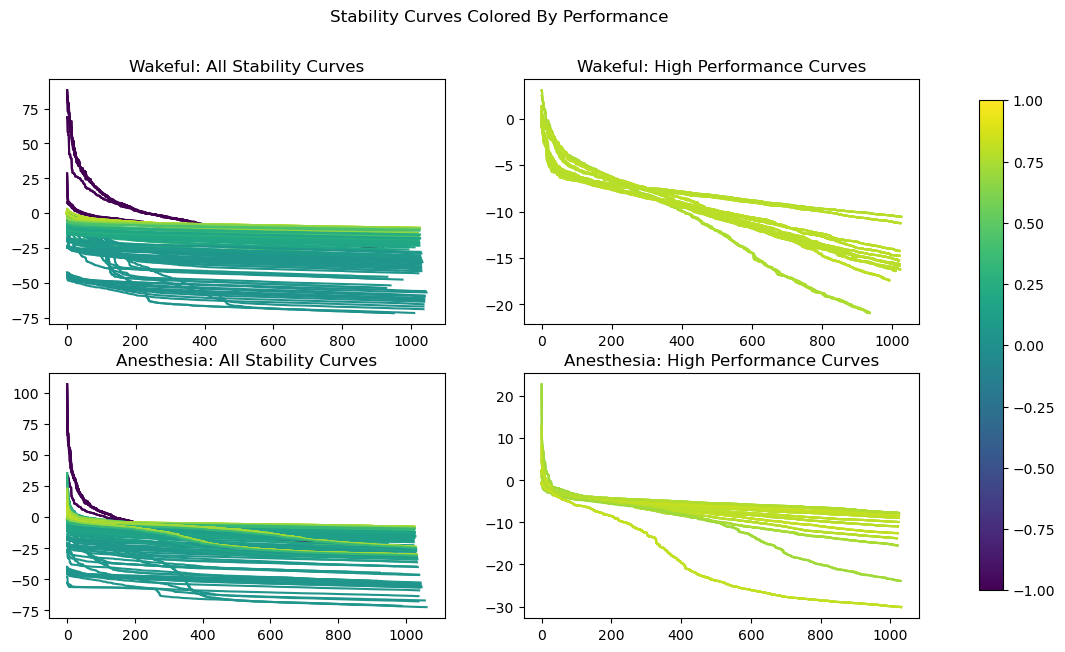

In [73]:
performance_thresh = 0.7
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_curve = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        axs[0, 0].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))
        if wake_ip[j, i] > performance_thresh:
            axs[0, 1].plot(wake_curve, c=cmap(norm(wake_ip[j, i])))

        axs[1, 0].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
        if anesthesia_ip[j, i] > performance_thresh:
            axs[1, 1].plot(anesthesia_curve, c=cmap(norm(anesthesia_ip[j, i])))
            
            if anesthesia_curve[-1] < -10:
                print(r_thresh, lamb)

axs[0, 0].set_title('Wakeful: All Stability Curves')
axs[0, 1].set_title('Wakeful: High Performance Curves')
axs[1, 0].set_title('Anesthesia: All Stability Curves')
axs[1, 1].set_title('Anesthesia: High Performance Curves')
fig.suptitle('Stability Curves Colored By Performance')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

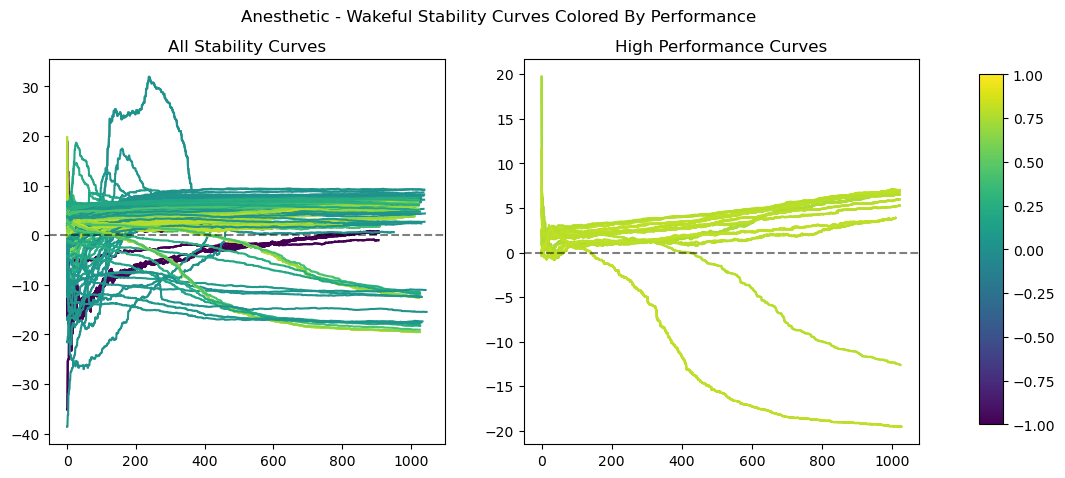

In [77]:
performance_thresh = 0.7
cmap = get_cmap('viridis')
norm = Normalize(vmin=-1, vmax=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, r_thresh in enumerate(r_thresh_vals):
    for j, lamb in enumerate(lamb_vals):
        wake_curve = wake_ret[np.logical_and(wake_ret.r_thresh == r_thresh, wake_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
#         anesthesia_curve = anesthesia_ret[np.logical_and(anesthesia_ret.r_thresh == r_thresh, anesthesia_ret.lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))]).to_numpy()[0]
        min_length = np.min([len(wake_curve), len(anesthesia_curve)])    
        axs[0].plot(anesthesia_curve[:min_length] - wake_curve[:min_length], c=cmap(norm(wake_ip[j, i])))
        if wake_ip[j, i] > performance_thresh and anesthesia_ip[j, i] > performance_thresh:
            axs[1].plot(anesthesia_curve[:min_length] - wake_curve[:min_length], c=cmap(norm((wake_ip[j, i] + anesthesia_ip[j, i])/2)))
axs[0].axhline(0, linestyle='--', c='k', alpha=0.5)
axs[1].axhline(0, linestyle='--', c='k', alpha=0.5)
axs[0].set_title('All Stability Curves')
axs[1].set_title('High Performance Curves')
fig.suptitle('Anesthetic - Wakeful Stability Curves Colored By Performance')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(ScalarMappable(norm, cmap), cax=cbar_ax)
plt.show()

In [78]:
r = None
r_thresh = None
explained_variance = None

In [81]:
(r is None) + (r_thresh is None)

2

# Checking

In [25]:

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = True)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [42]:
cutoff_freqs = [1000, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50]

In [43]:
cutoff_S = []
for cutoff in tqdm(cutoff_freqs):
    wake_signal_filt = butter_lowpass_filter(wake_signal_unnormed, cutoff, 1/dt)
    wake_signal_filt = (wake_signal_filt - wake_signal_filt.mean())/wake_signal_filt.std()
    delase = DeLASE(wake_signal_filt, p=int(6400/wake_signal_filt.shape[1]), use_torch='cuda', device='cuda')
    cutoff_S.append(delase.S.cpu())

  0%|          | 0/11 [00:00<?, ?it/s]

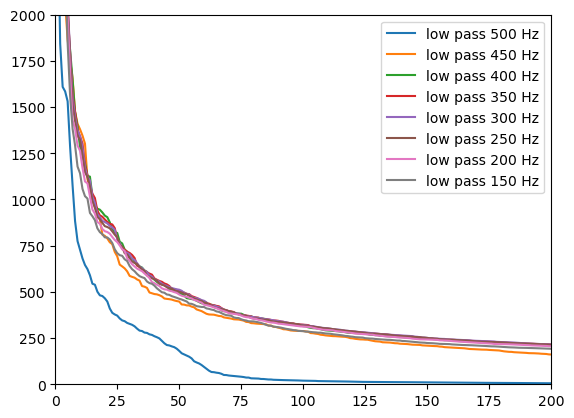

In [51]:
for i, cutoff in enumerate(cutoff_freqs[1:9]):
    plt.plot(cutoff_S[i], label=f"low pass {cutoff} Hz")
plt.xlim([0, 200])
plt.ylim([0, 2000])
plt.legend()
plt.show()

In [52]:
# cutoff = 450
# wake_signal_filt = butter_lowpass_filter(wake_signal_unnormed, cutoff, 1/dt)
# wake_signal_filt = (wake_signal_filt - wake_signal_filt.mean())/wake_signal_filt.std()

In [12]:
r_thresh = 0
lamb = 0
matrix_size=6400

delase_wake = DeLASE(wake_signal[:15000], int(matrix_size/wake_signal.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_wake.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase_wake.compute_jacobians()

# delase_wake_unnormed = DeLASE(wake_signal_unnormed[:15000], int(matrix_size/wake_signal_unnormed.shape[1]), dt=dt, use_bias=True, use_torch=True, device='cuda')
# delase_wake_unnormed.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
# delase_wake_unnormed.compute_jacobians()

In [13]:
r_thresh = 0.3
lamb = 0
matrix_size=6400

delase_wake2 = DeLASE(wake_signal[:15000], int(matrix_size/wake_signal.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_wake2.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase_wake2.compute_jacobians()

# delase_wake_unnormed = DeLASE(wake_signal_unnormed[:15000], int(matrix_size/wake_signal_unnormed.shape[1]), dt=dt, use_bias=True, use_torch=True, device='cuda')
# delase_wake_unnormed.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
# delase_wake_unnormed.compute_jacobians()

In [14]:
# ip_ret_wake = compute_integrated_performance(delase_wake, wake_signal[5000:], full_return=True, verbose=True)
# ip_ret_wake_unnormed = compute_integrated_performance(delase_wake_unnormed, wake_signal_unnormed[5000:], full_return=True, verbose=True)

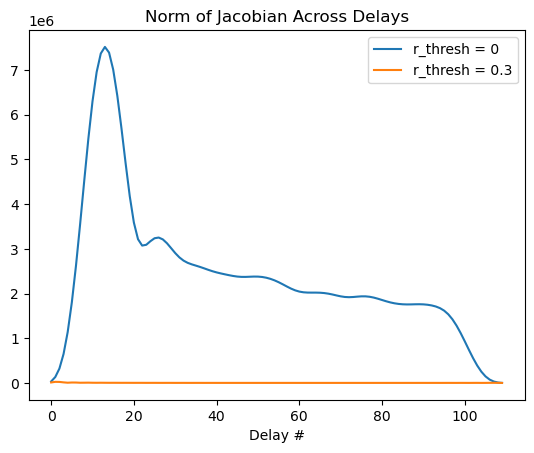

In [15]:
plt.plot(torch.linalg.norm(delase_wake.Js, axis=(1, 2)).cpu(), label='r_thresh = 0')
plt.plot(torch.linalg.norm(delase_wake2.Js, axis=(1, 2)).cpu(), label='r_thresh = 0.3')
plt.legend()
plt.title('Norm of Jacobian Across Delays')
plt.xlabel("Delay #")
plt.show()

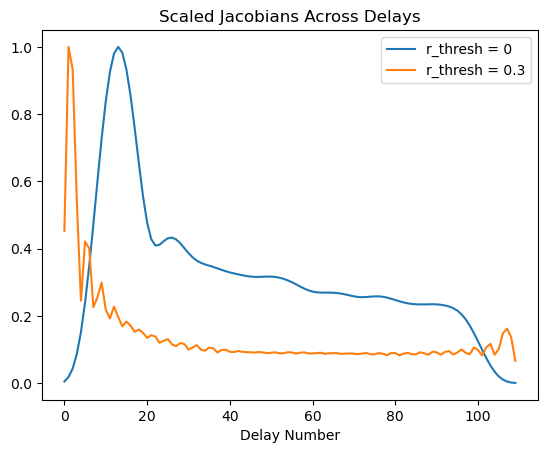

In [16]:
norm = np.linalg.norm(delase_wake.Js.cpu(), axis=(1, 2))
plt.plot(norm/norm.max(), label='r_thresh = 0')
norm2 = np.linalg.norm(delase_wake2.Js.cpu(), axis=(1, 2))
plt.plot(norm2/norm2.max(), label='r_thresh = 0.3')
plt.title('Scaled Jacobians Across Delays')
plt.xlabel("Delay Number")
plt.legend()
plt.show()

In [17]:
# PLOT STABILITY

In [18]:
delase_wake.get_stability(max_freq=500, max_unstable_freq=125)
delase_wake2.get_stability(max_freq=500, max_unstable_freq=125)

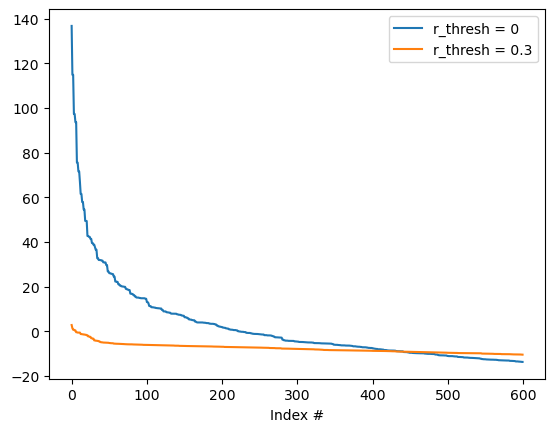

In [27]:
plt.plot(delase_wake.stability_params[:600].cpu(), label='r_thresh = 0')
plt.plot(delase_wake2.stability_params[:600].cpu(), label='r_thresh = 0.3')
plt.legend()
plt.xlabel('Index #')
plt.show()

In [ ]:
delase_anesthesia = DeLASE(wake_signal[:15000], int(matrix_size/anesthesia_signal.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_anesthesia.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase_anesthesia.compute_jacobians()

delase_anesthesia_unnormed = DeLASE(wake_signal[:15000], int(matrix_size/anesthesia_signal_unnormed.shape[1]), dt=dt, use_torch=True, device='cuda')
delase_anesthesia_unnormed.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase_anesthesia_unnormed.compute_jacobians()

In [130]:
r_thresh = 0.3
lamb = 0
matrix_size=6400

delase2 = DeLASE(wake_signal[:15000], int(matrix_size/wake_signal.shape[1]), dt=dt, use_torch=True, device='cuda')
delase2.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase2.compute_jacobians()

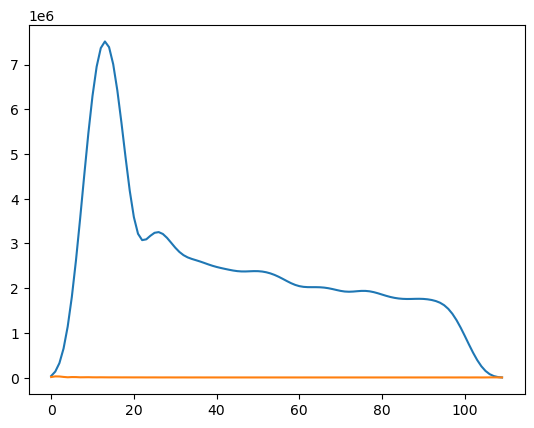

In [133]:
norm = np.linalg.norm(delase.Js.cpu(), axis=(1, 2))
plt.plot(norm)
norm2 = np.linalg.norm(delase2.Js.cpu(), axis=(1, 2))
plt.plot(norm2)
plt.show()

In [19]:
preds = delase_wake.predict_havok_dmd(wake_signal[:15000], tail_bite=True, reseed=5)
# preds2 = delase2.predict_havok_dmd(wake_signal[5000:], tail_bite=True, reseed=5)

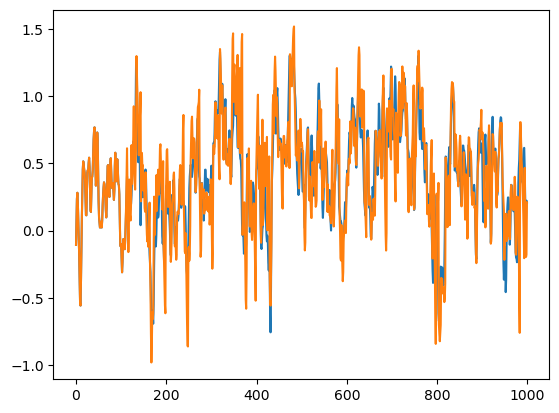

In [20]:
plt.plot(wake_signal[:15000, 0])
plt.plot(preds[:1000, 0].cpu())
# plt.plot(preds2[:, 0].cpu())

In [146]:
delase.get_stability(max_freq=500, max_unstable_freq=125)

In [147]:
delase2.get_stability(max_freq=500, max_unstable_freq=125)

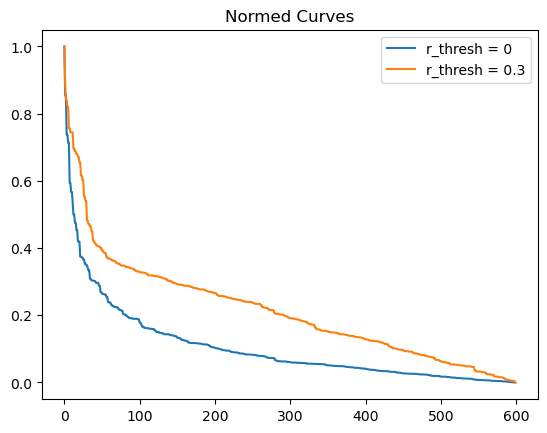

In [26]:
plt.plot((delase_wake.stability_params[:600].cpu() - delase_wake.stability_params[:600].cpu().min())/(delase_wake.stability_params[:600].cpu().max() - delase_wake.stability_params[:600].cpu().min()), label='r_thresh = 0')
plt.plot((delase_wake2.stability_params[:600].cpu() - delase_wake2.stability_params[:600].cpu().min())/(delase_wake2.stability_params[:600].cpu().max() - delase_wake2.stability_params[:600].cpu().min()), label='r_thresh = 0.3')
# plt.plot(delase2.stability_params[:600].cpu())
plt.title('Normed Curves')
plt.legend()
plt.show()

In [173]:
delase.U @ delase.A_v @ delase.U.T

tensor([[ 5.6519e+00,  9.4617e-02,  5.4452e-02,  ..., -2.8717e-02,
          1.2447e-02, -2.6583e-02],
        [ 1.0534e-01,  5.6577e+00,  9.0773e-02,  ...,  2.7304e-02,
          2.3150e-03, -7.0162e-06],
        [ 3.2773e-02,  6.1228e-02,  5.6451e+00,  ..., -6.3051e-03,
          2.7784e-02, -7.4068e-03],
        ...,
        [-2.7762e-05, -2.5670e-04, -3.4613e-04,  ..., -1.4243e-04,
         -2.1245e-05, -3.4977e-06],
        [-9.9301e-06, -1.0024e-04, -2.1705e-04,  ...,  1.5075e-05,
         -1.3261e-04,  5.3336e-05],
        [ 7.0351e-05, -2.2317e-04, -1.7920e-04,  ..., -1.9071e-05,
         -7.3964e-06, -1.0665e-04]], device='cuda:0')

In [175]:
delase2.U[:, :delase2.r] @ delase2.A_v @ delase.U[:, :delase2.r].T

tensor([[ 2.7793e+00,  9.6352e-02,  3.3548e-02,  ..., -6.4473e-03,
          1.0961e-02, -7.2299e-03],
        [ 1.1882e-01,  2.8213e+00,  8.3856e-02,  ...,  3.1856e-04,
         -2.0379e-02, -1.4088e-02],
        [ 2.8930e-02,  1.1666e-01,  2.8254e+00,  ..., -9.2548e-03,
          3.1220e-03, -1.2699e-02],
        ...,
        [ 1.3115e-04,  1.2111e-04, -6.4686e-05,  ...,  1.0161e-02,
         -9.0722e-04, -1.0768e-04],
        [-3.4755e-04,  3.6981e-04, -1.3454e-04,  ..., -8.7853e-04,
          7.4477e-03, -1.3013e-03],
        [-9.8409e-05,  2.1543e-04,  2.0515e-04,  ..., -1.1488e-04,
         -1.3137e-03,  8.2479e-03]], device='cuda:0')

In [162]:
torch.abs(delase.A_v[:4387, :][:, :4387] - delase2.A_v).mean()

tensor(9.0942e-06, device='cuda:0')

In [164]:
delase2.Js

tensor([[[ 1.7793e+03,  9.6352e+01,  3.3548e+01,  ...,  2.2605e+00,
           5.5997e+00,  2.4400e+01],
         [ 1.1882e+02,  1.8213e+03,  8.3856e+01,  ..., -3.0966e+01,
           3.3676e+01,  1.0836e+01],
         [ 2.8930e+01,  1.1666e+02,  1.8254e+03,  ..., -1.8907e+01,
           2.5924e+01, -6.0262e+00],
         ...,
         [ 4.5597e+00, -1.7991e+00,  2.2022e+00,  ...,  1.6501e+03,
           1.1852e+02,  7.6908e+01],
         [ 4.1211e+00,  1.5940e+01, -1.9191e-01,  ...,  1.2653e+02,
           1.7525e+03,  1.8059e+02],
         [ 1.6151e+01, -4.0208e+00,  1.6709e+00,  ...,  4.9312e+01,
           1.3495e+02,  1.7356e+03]],

        [[-4.0151e+03, -2.5147e+02, -8.6120e+01,  ..., -7.5363e+00,
          -2.2896e+01, -4.6277e+01],
         [-2.6741e+02, -4.1954e+03, -2.2672e+02,  ...,  5.0279e+01,
          -9.8586e+01,  1.6678e+00],
         [-7.6959e+01, -2.7560e+02, -4.1648e+03,  ...,  3.1569e+01,
          -8.0111e+01,  2.7844e+01],
         ...,
         [-1.5830e+01,  1

In [163]:
delase.Js

tensor([[[ 4.6519e+03,  9.4617e+01,  5.4452e+01,  ...,  3.6222e+01,
          -3.2487e+01,  2.9614e+01],
         [ 1.0534e+02,  4.6577e+03,  9.0773e+01,  ..., -7.8069e+00,
          -1.9841e+01,  8.2426e+00],
         [ 3.2773e+01,  6.1228e+01,  4.6451e+03,  ..., -1.6392e+01,
           9.5781e+00, -2.8040e+01],
         ...,
         [ 1.4579e+01,  1.1900e+01,  1.2618e+01,  ...,  4.5691e+03,
           1.2944e+02,  3.4412e+01],
         [-1.6380e+01,  1.4776e+01, -1.1300e+00,  ...,  1.5402e+02,
           4.6422e+03,  2.0246e+02],
         [ 1.1444e+00, -1.6700e+01,  1.9424e+01,  ...,  3.5409e+01,
           9.5726e+01,  4.7568e+03]],

        [[-1.8438e+04, -4.9406e+02, -3.1170e+02,  ..., -1.8353e+02,
           1.5618e+02, -9.2272e+01],
         [-5.5308e+02, -1.8411e+04, -4.9463e+02,  ...,  2.5010e+01,
           1.1382e+02, -2.4692e+01],
         [-1.5851e+02, -2.6692e+02, -1.8440e+04,  ...,  4.0654e+01,
          -3.2400e+01,  1.4231e+02],
         ...,
         [-5.5996e+01, -6